In [2]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [28]:
import torch
import open_clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
from io import BytesIO
from transformers import AutoProcessor, AutoModel

class OpenCLIPInference:
    def __init__(self):
        """
        モデル初期化（use_siglip=Falseの時CLIPを使用）
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"使用デバイス: {self.device}")

        # モデルとトークナイザーを読み込み
        model_name='ViT-B-32'
        pretrained='laion2b_s34b_b79k'
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(
            model_name, pretrained=pretrained
        )
        self.tokenizer = open_clip.get_tokenizer(model_name)

        self.model.to(self.device)
        self.model.eval()
        print(f"モデル読み込み完了: {model_name} ({pretrained})")

    def infer(self, images, texts):
        image_tensor = torch.stack([self.preprocess(image) for image in images])

        with torch.no_grad():
            image_tensor = image_tensor.to(self.device)
            image_features = self.model.encode_image(image_tensor)
            text_tokens = self.tokenizer(texts).to(self.device)
            text_features = self.model.encode_text(text_tokens)
            # L2正規化
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            similarity_matrix = torch.matmul(image_features, text_features.T)
        return similarity_matrix.cpu().numpy()

class SigLIPInference:
    def __init__(self) -> None:
        HF_MODEL = "google/siglip-base-patch16-256-multilingual"
        self.device = "cuda" if torch.cuda.is_available() \
            else ("mps" if torch.backends.mps.is_available() else "cpu")
        self.model = AutoModel.from_pretrained(HF_MODEL)
        self.processor = AutoProcessor.from_pretrained(HF_MODEL)

    def infer(self, images, texts):
        inputs = self.processor(
            text=texts, images=images, padding="max_length", return_tensors="pt"
        ).to(self.device)
        self.model.to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        similarity_matrix = outputs.logits_per_image
        return similarity_matrix.cpu().numpy()


def load_images(image_paths):
    """
    複数の画像を読み込み、前処理を適用

    Args:
        image_paths: 画像パスのリスト（ローカルパスまたはURL）

    Returns:
        処理済み画像のテンソル
    """
    images = []
    valid_paths = []

    for path in image_paths:
        try:
            if str(path).startswith(('http://', 'https://')):
                # URLから画像を読み込み
                response = requests.get(path)
                image = Image.open(BytesIO(response.content)).convert('RGB')
            else:
                # ローカルファイルから画像を読み込み
                image = Image.open(path).convert('RGB')

            # 前処理を適用
            images.append(image)
            valid_paths.append(path)
            print(f"画像読み込み成功: {path}")

        except Exception as e:
            print(f"画像読み込みエラー ({path}): {e}")
            continue

    if not images:
        raise ValueError("有効な画像が見つかりませんでした")

    return images, valid_paths



def create_heatmap(similarity_matrix, image_labels=None, text_labels=None,
                    title="Image-Text Similarity Heatmap", figsize=(12, 8)):
    """
    類似度行列のヒートマップを作成

    Args:
        similarity_matrix: 類似度行列
        image_labels: 画像のラベル（オプション）
        text_labels: テキストのラベル（オプション）
        title: グラフのタイトル
        figsize: 図のサイズ
    """
    plt.figure(figsize=figsize)

    # デフォルトラベルを作成
    if image_labels is None:
        image_labels = [f"Image_{i+1}" for i in range(similarity_matrix.shape[0])]
    if text_labels is None:
        text_labels = [f"Text_{i+1}" for i in range(similarity_matrix.shape[1])]

    # ヒートマップを作成
    sns.heatmap(
        similarity_matrix,
        xticklabels=text_labels,
        yticklabels=image_labels,
        annot=True,
        fmt='.3f',
        cmap='viridis',
        center=0,
        square=True
    )

    plt.title(title)
    plt.xlabel('Texts')
    plt.ylabel('Images')
    plt.tight_layout()
    plt.show()

    return plt.gcf()

def inference(model, image_paths, texts, create_heatmap_viz=True):
    """
    画像とテキストの推論を実行し、類似度を計算

    Args:
        image_paths: 画像パスのリスト
        texts: テキストのリスト
        create_heatmap_viz: ヒートマップを作成するかどうか

    Returns:
        dict: 結果を含む辞書
    """
    # 画像を読み込み・前処理
    images, valid_image_paths = load_images(image_paths)

    # 類似度行列を計算
    print("類似度行列を計算中...")
    similarity_matrix = model.infer(images, texts)

    # 結果を整理
    results = {
        'similarity_matrix': similarity_matrix,
        'image_paths': valid_image_paths,
        'texts': texts
    }

    # ヒートマップを作成
    if create_heatmap_viz:
        image_labels = [Path(p).stem for p in valid_image_paths]
        create_heatmap(
            similarity_matrix,
            image_labels=image_labels,
            text_labels=texts
        )

    # 最も類似度の高いペアを表示
    print_top_similarities(similarity_matrix, valid_image_paths, texts)

    return results

def print_top_similarities(similarity_matrix, image_paths, texts, top_k=5):
    """
    最も類似度の高いペアを表示
    """
    print(f"\n=== Top {top_k} 類似ペア ===")

    # 全ての組み合わせの類似度を取得
    similarities = []
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            similarities.append({
                'image_idx': i,
                'text_idx': j,
                'similarity': similarity_matrix[i, j],
                'image_path': Path(image_paths[i]).name,
                'text': texts[j]
            })

    # 類似度でソート
    similarities.sort(key=lambda x: x['similarity'], reverse=True)

    # Top-Kを表示
    for k, sim in enumerate(similarities[:top_k]):
        print(f"  {k+1}. {sim['image_path']} ↔ '{sim['text']}' "
                f"(類似度: {sim['similarity']:.4f})")



使用デバイス: cuda
モデル読み込み完了: ViT-B-32 (laion2b_s34b_b79k)
画像読み込み成功: /content/a1w1.jpg
画像読み込み成功: /content/a1w1_red_circle_a.jpg
画像読み込み成功: /content/a1w1_red_circle_w.jpg
類似度行列を計算中...


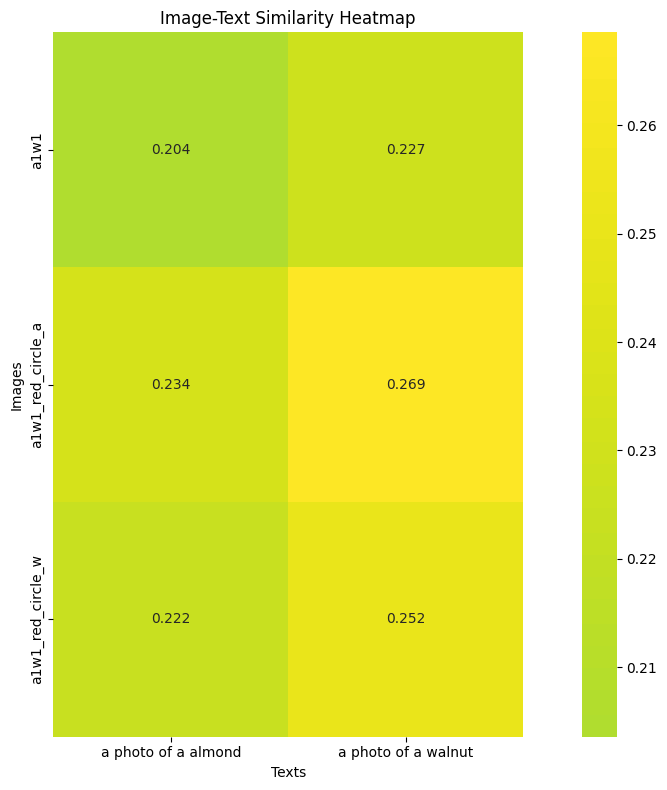


=== Top 5 類似ペア ===
  1. a1w1_red_circle_a.jpg ↔ 'a photo of a walnut' (類似度: 0.2686)
  2. a1w1_red_circle_w.jpg ↔ 'a photo of a walnut' (類似度: 0.2517)
  3. a1w1_red_circle_a.jpg ↔ 'a photo of a almond' (類似度: 0.2343)
  4. a1w1.jpg ↔ 'a photo of a walnut' (類似度: 0.2267)
  5. a1w1_red_circle_w.jpg ↔ 'a photo of a almond' (類似度: 0.2224)


<Figure size 640x480 with 0 Axes>

In [31]:
use_siglip=False

# CLIP/SigLIPモデルを初期化
if use_siglip:
    model = SigLIPInference()
else:
    model = OpenCLIPInference()

# サンプル画像パス（ローカルファイルまたはURL）
image_paths = [
    "/content/a1w1.jpg",
    "/content/a1w1_red_circle_a.jpg",
    "/content/a1w1_red_circle_w.jpg",
    # URLも使用可能
    # "https://example.com/image.jpg"
]

# サンプルテキスト
texts = [
    "a photo of a almond",
    "a photo of a walnut",
]

results = inference(model, image_paths, texts)

In [19]:
a = results["similarity_matrix"]

In [20]:
a -= a[0]

In [21]:
a

array([[0.        , 0.        ],
       [0.03072801, 0.04185104],
       [0.01879199, 0.02496383]], dtype=float32)